In [1]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import os 
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

dirs = ['../DataGeneration/Python', './net/']
for d in dirs:
    if d not in sys.path:
        sys.path.append(d)

import Sample
import Dataloader

from Transformer import Transformer

In [15]:
DATASET_PATH = '../Dataset/CC10k.npy'
N_WORKERS = 0

# From data
d_input = 4 # 10 Ages + 4 thermochronometers*(10 samples))
d_output = 7+3*5+5  # Output sequence 7 constants + 3 exhumation_history params * 5 rates + 5 uplift rates
seqlen=10

# Hyperparameters
BATCH_SIZE = 5
D_MODEL = 64
q = 8 
v = 8
h = 8
Ne = 4
Nd = 4
DROPOUT = 0.3

LR = .003

In [16]:
geoData = Dataloader.formattedLoader(d_input, d_output, DATASET_PATH) # Get input data formatted for network
data_train, data_val, data_test = random_split(geoData, (9000, 500, 500))

dataloader_train = DataLoader(data_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

dataloader_val = DataLoader(data_val, batch_size=BATCH_SIZE, shuffle=True, num_workers=N_WORKERS)

dataloader_test = DataLoader(data_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=N_WORKERS)

In [17]:
optimizePrime = Transformer(d_input, seqlen, d_output, D_MODEL, q, v, h, Ne, Nd, BATCH_SIZE, DROPOUT)
optimizer = torch.optim.Adam(optimizePrime.parameters(), lr=LR)
loss_function = nn.MSELoss()

In [23]:
model_save_path = f'Checkpoints/model_{datetime.datetime.now().strftime("%Y_%m_%d__%H%M%S")}.pth'
epoch_loss_best = np.inf

batch_loss = []
epoch_loss = []
epoch_val_loss = []
EPOCHS = 30

X = 0
Y = 0

for epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(dataloader_train.dataset), desc=f"[Epoch {epoch+1:3d}/{EPOCHS}]") as pbar:

        for i, (x, y) in enumerate(dataloader_train):
            
            # Zero gradients
            optimizer.zero_grad()
            x = x.float()
            yhat = optimizePrime(x)
            loss = loss_function(y.float(), yhat)

            # Backpass
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())
            running_loss+= loss.item()
            pbar.set_postfix({'loss': running_loss/(epoch+1)})
            pbar.update(x.shape[0])
        epoch_loss.append(running_loss)
    if running_loss < epoch_loss_best:
        epoch_loss_best = running_loss
        torch.save(optimizePrime.state_dict(), model_save_path)    


[Epoch  30/30]: 100%|██████████| 9000/9000 [01:02<00:00, 144.46it/s, loss=1.28e+3]


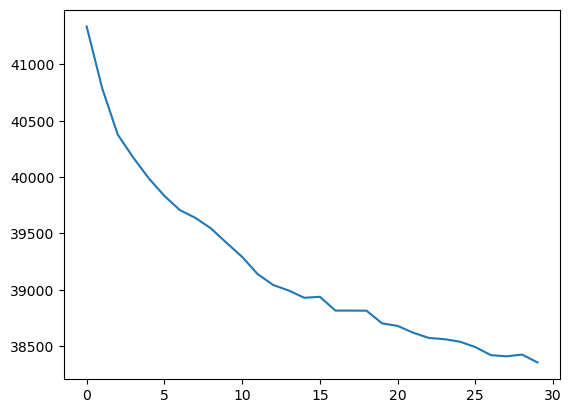

In [24]:
plt.plot(range(len(epoch_loss)), epoch_loss)

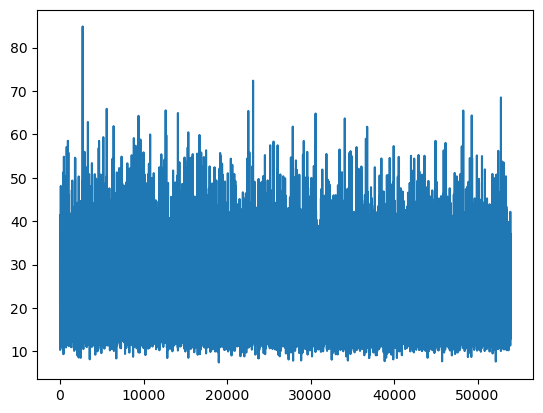

In [25]:
plt.plot(range(len(batch_loss)), batch_loss)

In [26]:
min(batch_loss)

7.4664626121521

In [27]:
for i, (x, y) in enumerate(dataloader_train):        
    # Zero gradients
    x = x.float()
    y = y
    break
    yhat = optimizePrime(x)
    

In [28]:
optimizePrime(x)[0], y[0]

(tensor([2.5615e+01, 3.1211e+00, 2.3438e+00, 2.0851e+00, 4.4667e+01, 1.0523e+02,
         5.3139e+00, 6.8994e+00, 6.2930e+00, 1.1823e+01, 1.3248e+01, 6.4414e+00,
         1.3015e+01, 1.4407e+01, 4.8439e+00, 7.5535e+00, 1.0243e+01, 2.3605e+00,
         4.4032e+00, 3.6337e+00, 9.6864e-01, 1.6651e+00, 5.9819e-01, 2.4883e-01,
         9.5986e-02, 1.0845e-01, 2.1005e-01], grad_fn=<SelectBackward0>),
 tensor([ 28.0000,   2.0000,   2.6000,   2.1700,  47.0000, 120.1000,  11.0000,
           6.8000,   9.1000,  19.7000,  15.9000,  14.0000,  42.5000,   2.1600,
           3.0300,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
           0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        dtype=torch.float64))